In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.nn.utils.parametrizations import spectral_norm

In [2]:
# Root directory for dataset
dataroot = "data/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1

In [3]:
class SelfAttention(nn.Module):
    
    def __init__(self, n_channels):
        super(SelfAttention, self).__init__()
        self.query, self.key, self.value = [nn.Conv1d(n_channels, c, 1) for c in (n_channels//8, n_channels//8, n_channels)]
        self.gamma = nn.Parameter(torch.Tensor([0.]))

    def forward(self, x):
        size = x.size()
        x = x.view(*size[:2],-1)
        f, g, h = self.query(x), self.key(x), self.value(x)
        beta = F.softmax(torch.bmm(f.transpose(1,2), g), dim=1)
        o = self.gamma * torch.bmm(h, beta) + x
        return o.view(*size).contiguous()

class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(            
                                    spectral_norm(nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias = False)),
                                    nn.BatchNorm2d(ngf * 8),
                                    nn.ReLU(True),
            
                                    spectral_norm(nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias = False)),
                                    nn.BatchNorm2d(ngf * 4),
                                    nn.ReLU(True),

                                    spectral_norm(nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias = False)),
                                    nn.BatchNorm2d(ngf * 2),
                                    nn.ReLU(True),
                        
                                    spectral_norm(nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias = False)),
                                    nn.BatchNorm2d(ngf),
                                    nn.ReLU(True),
            
                                    SelfAttention(ngf),
            
                                    spectral_norm(nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias = False)),
                                    nn.Tanh()

                                 )
                      
        
        
    def forward(self, input):
        return self.main(input)
        
        
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
                                    spectral_norm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)),
                                    nn.LeakyReLU(0.2, inplace=True),

                                    spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
                                    nn.BatchNorm2d(ndf * 2),
                                    nn.LeakyReLU(0.2, inplace=True),

                                    spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
                                    nn.BatchNorm2d(ndf * 4),
                                    nn.LeakyReLU(0.2, inplace=True),

                                    spectral_norm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),
                                    nn.BatchNorm2d(ndf * 8),
                                    nn.LeakyReLU(0.2, inplace=True),
            
                                    SelfAttention(ndf * 8),
            
                                    spectral_norm(nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)),
                                    nn.Sigmoid()
                                )
        
    def forward(self, input):
        return self.main(input)

In [4]:
# Create the generator
device = torch.device("cuda:0")
netG = Generator().to(device)

In [5]:
netD = Discriminator().to(device)

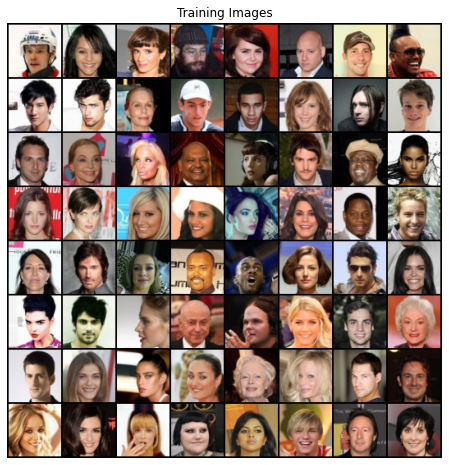

In [6]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
test_dataset = torch.utils.data.Subset(dataset, torch.arange(3000))

In [8]:
import torch.optim as optim
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=0.0004, betas=(0, 0.9))
optimizerG = optim.Adam(netG.parameters(), lr=0.0001, betas=(0, 0.9))

In [9]:
def initialize_fn(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
import logging
import matplotlib.pyplot as plt

import numpy as np

from torchsummary import summary

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.utils as vutils

from ignite.engine import Engine, Events
import ignite.distributed as idist

In [11]:
import ignite

In [12]:
ignite.utils.manual_seed(999)
ignite.utils.setup_logger(name="ignite.distributed.auto.auto_dataloader", level=logging.WARNING)
ignite.utils.setup_logger(name="ignite.distributed.launcher.Parallel", level=logging.WARNING)

<Logger ignite.distributed.launcher.Parallel (WARNING)>

In [13]:
train_dataloader = idist.auto_dataloader(
    dataset, 
    batch_size=batch_size, 
    num_workers=2, 
    shuffle=True, 
    drop_last=True,
)

test_dataloader = idist.auto_dataloader(
    test_dataset, 
    batch_size=batch_size, 
    num_workers=2, 
    shuffle=False, 
    drop_last=True,
)

In [14]:
def training_step(engine, data):
    # Set the models for training
    netG.train()
    netD.train()

    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))

    netD.zero_grad()
    # Format batch
    real = data[0].to(idist.device())
    b_size = real.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=idist.device())
    # Forward pass real batch through D
    output1 = netD(real).view(-1)
    # Calculate loss on all-real batch
    errD_real = criterion(output1, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=idist.device())
    # Generate fake image batch with G
    fake = netG(noise)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output2 = netD(fake.detach()).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output2, label)
    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD_fake.backward()
    # Compute error of D as sum over the fake and the real batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()

    # (2) Update G network: maximize log(D(G(z)))
    
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output3 = netD(fake).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output3, label)
    # Calculate gradients for G
    errG.backward()
    # Update G
    optimizerG.step()

    return {
        "Loss_G" : errG.item(),
        "Loss_D" : errD.item(),
        "D_x": output1.mean().item(),
        "D_G_z1": output2.mean().item(),
        "D_G_z2": output3.mean().item(),
    }

In [15]:
trainer = Engine(training_step)

In [16]:
@trainer.on(Events.STARTED)
def init_weights():
    netD.apply(initialize_fn)
    netG.apply(initialize_fn)

In [17]:
G_losses = []
D_losses = []

@trainer.on(Events.ITERATION_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    G_losses.append(o["Loss_G"])
    D_losses.append(o["Loss_D"])

In [18]:
@trainer.on(Events.ITERATION_COMPLETED)
def save_model(engine):
    o = engine.state.output
    G_losses.append(o["Loss_G"])
    D_losses.append(o["Loss_D"])

In [19]:
img_list = []

@trainer.on(Events.ITERATION_COMPLETED(every=500))
def store_images(engine):
    with torch.no_grad():
        fake = netG(fixed_noise).cpu()
    img_list.append(fake)

In [20]:
from ignite.metrics import FID, InceptionScore

In [21]:
fid_metric = FID(device=idist.device())
is_metric = InceptionScore(device=idist.device(), output_transform=lambda x: x[0])

In [22]:
import PIL.Image as Image


def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)


def evaluation_step(engine, batch):
    with torch.no_grad():
        noise = torch.randn(batch_size, nz, 1, 1, device=idist.device())
        netG.eval()
        fake_batch = netG(noise)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        return fake, real

In [23]:
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")

In [24]:
fid_values = []
is_values = []

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(test_dataloader,max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    fid_values.append(fid_score)
    is_values.append(is_score)
    print(f"Epoch {engine.state.epoch}/{engine.state.max_epochs} Metric Scores - FID : {fid_score:4f}, IS : {is_score:4f}")

In [25]:
from ignite.metrics import RunningAverage

RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
RunningAverage(output_transform=lambda x: x["Loss_D"]).attach(trainer, 'Loss_D')

In [26]:
from ignite.contrib.handlers import ProgressBar


ProgressBar().attach(trainer, metric_names=['Loss_G','Loss_D'])
ProgressBar().attach(evaluator)

In [27]:
from ignite.handlers import Checkpoint, DiskSaver

def training(*args):
    to_save = {'trainer': trainer, 'netG': netG, 'netD': netD, 'optimizerG': optimizerG, 'optimizerD': optimizerD}
    handler = Checkpoint(to_save, DiskSaver('training', create_dir=True))
    trainer.add_event_handler(Events.EPOCH_COMPLETED, handler)
    trainer.run(train_dataloader, max_epochs=20)

In [28]:
with idist.Parallel(backend='gloo') as parallel:
    parallel.run(training)

Epoch 1/20 Metric Scores - FID : 0.089559, IS : 1.943605


Epoch 2/20 Metric Scores - FID : 0.047416, IS : 2.298128


Epoch 3/20 Metric Scores - FID : 0.034127, IS : 2.436673


Epoch 4/20 Metric Scores - FID : 0.027256, IS : 2.533518


Epoch 5/20 Metric Scores - FID : 0.031739, IS : 2.316833


Epoch 6/20 Metric Scores - FID : 0.026673, IS : 2.494256


Epoch 7/20 Metric Scores - FID : 0.028989, IS : 2.460296


Epoch 8/20 Metric Scores - FID : 0.034047, IS : 2.428228


Epoch 9/20 Metric Scores - FID : 0.037218, IS : 2.422265


Epoch 10/20 Metric Scores - FID : 0.034845, IS : 2.399761


Epoch 11/20 Metric Scores - FID : 0.034908, IS : 2.499713


Epoch 12/20 Metric Scores - FID : 0.018300, IS : 2.624281


Epoch 13/20 Metric Scores - FID : 0.034841, IS : 2.509862


Epoch 14/20 Metric Scores - FID : 0.048919, IS : 2.468668


Epoch 15/20 Metric Scores - FID : 0.027867, IS : 2.591309


Epoch 16/20 Metric Scores - FID : 0.042007, IS : 2.462686


Epoch 17/20 Metric Scores - FID : 0.024061, IS : 2.464833


Epoch 18/20 Metric Scores - FID : 0.020806, IS : 2.564691


Epoch 19/20 Metric Scores - FID : 0.029966, IS : 2.561378


Epoch 20/20 Metric Scores - FID : 0.021228, IS : 2.542200


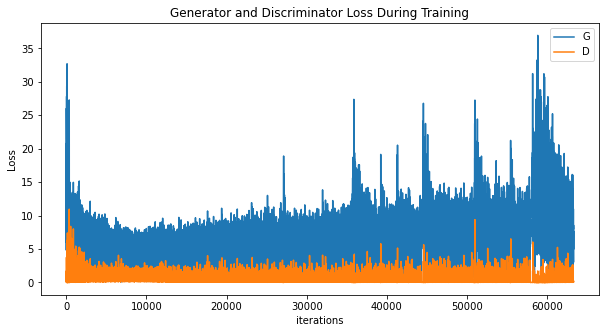

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

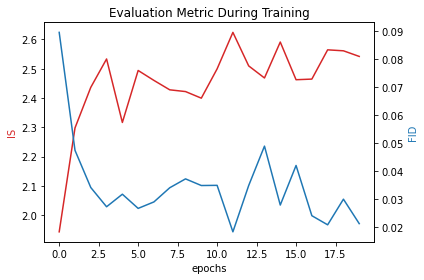

In [30]:
fig, ax1 = plt.subplots()

plt.title("Evaluation Metric During Training")

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('IS', color=color)
ax1.plot(is_values, color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('FID', color=color)
ax2.plot(fid_values, color=color)

fig.tight_layout()

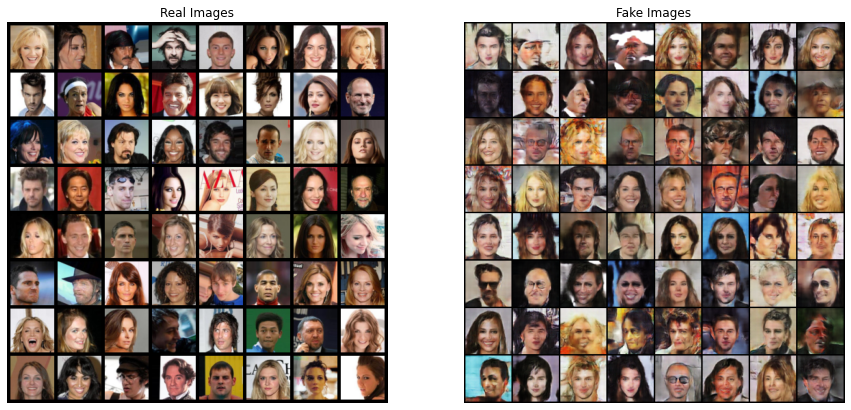

In [35]:
import matplotlib.pyplot as plt
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1], padding=2, normalize=True).cpu(),(1,2,0)))